# RT Feature Evaluation

Comprehensive evaluation of RT (Retention Time) features on full dataset with target-decoy analysis.


In [6]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from peptdeep.rescore.fdr import calc_fdr

from dia_aspire_rescore.io import read_diann2
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from dia_aspire_rescore.features import RTFeatureGenerator
from dia_aspire_rescore.plot import plot_target_decoy_dist, plot_qvalues

# Create output directory
output_dir = Path('../output/rt')
output_dir.mkdir(parents=True, exist_ok=True)


In [7]:
# Load data
psm_df_all = read_diann2("../../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_all = psm_df_all.sort_values(by='nAA', ascending=True).reset_index(drop=True)
print(f"Loaded {len(psm_df_all)} PSMs")
print(f"Target: {(psm_df_all['decoy']==0).sum()}, Decoy: {(psm_df_all['decoy']==1).sum()}")


Loaded 338839 PSMs
Target: 174407, Decoy: 164432


In [8]:
psm_df_all


,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,fdr1_search1,fdr2_search1,fdr1_search2,fdr2_search2,mods,mod_sites,nAA,rt_norm,precursor_mz,ccs
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,YQYYHRYY,3,44.166344,44.104832,44.227886,0.0,1/sp|O96000|NDUBA_HUMAN,1/sp|O96000|NDUBA_HUMAN,,...,0.264773,1.000000,0.0,0.0,,,8,0.369029,419.189212,0.0
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,ERMGANSL,2,38.052963,37.930332,38.206379,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,0.157135,0.000124,0.0,0.0,,,8,0.317949,439.213452,0.0
2,20200317_QE_HFX2_LC3_DIA_RA957_R02,ERMGANSL,2,37.944874,37.852745,38.129253,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,0.157135,0.000124,0.0,0.0,,,8,0.317283,439.213452,0.0
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGASL,1,73.935051,73.812119,74.120216,0.0,1/sp|Q9Y6J0|CABIN_HUMAN,1/sp|Q9Y6J0|CABIN_HUMAN,,...,0.000224,0.000124,0.0,0.0,,,8,0.617759,711.403566,0.0
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGAEL,1,79.160156,79.067657,79.252640,0.0,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,,...,0.179222,1.000000,0.0,0.0,,,8,0.661417,753.414131,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338834,20200317_QE_HFX2_LC3_DIA_RA957_R02,SSFPSASLGKASVR,2,58.953045,58.828590,59.046440,0.0,1/sp|Q9NWN3|FBX34_HUMAN,1/sp|Q9NWN3|FBX34_HUMAN,,...,1.000000,1.000000,0.0,0.0,,,14,0.492947,697.375340,0.0
338835,20200317_QE_HFX2_LC3_DIA_RA957_R02,DAFNHLTTWLEDTR,3,107.905006,107.873901,108.122513,0.0,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,,...,0.443320,1.000000,0.0,0.0,,,14,0.902269,573.609276,0.0
338836,20200317_QE_HFX2_LC3_DIA_RA957_R02,DTFRPDLSSASFSR,3,73.220573,72.975151,73.312637,0.0,1/sp|Q13077|TRAF1_HUMAN,1/sp|Q13077|TRAF1_HUMAN,,...,1.000000,1.000000,0.0,0.0,,,14,0.612248,529.258355,0.0
338837,20200317_QE_HFX2_LC3_DIA_RA957_R01,SFHDPAGALQAAVR,2,75.013031,74.829079,75.197029,0.0,1/sp|O15533|TPSN_HUMAN,1/sp|O15533|TPSN_HUMAN,,...,1.000000,1.000000,0.0,0.0,,,14,0.626766,720.373132,0.0


In [9]:
# Select high-confidence PSMs for finetuning
psm_df_finetune = psm_df_all[
    psm_df_all['fdr1_search1'] < 0.005
].copy()
print(f"Selected {len(psm_df_finetune)} high-confidence PSMs for finetuning")


Selected 76843 high-confidence PSMs for finetuning


In [10]:
# Finetune RT model
config = FineTuneConfig()

finetuner = FineTuner(config)
finetuner.load_pretrained('generic')
finetuner.train_rt(psm_df_finetune)
print("RT model finetuned successfully")


2025-12-08 00:13:45> 10099 PSMs for RT model training/transfer learning
2025-12-08 00:13:45> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.13532289170793124
[Training] Epoch=2, lr=3e-05, loss=0.13027033263019153
[Training] Epoch=3, lr=4e-05, loss=0.12184958319578852
[Training] Epoch=4, lr=5e-05, loss=0.10927750808852059
[Training] Epoch=5, lr=6e-05, loss=0.09379580936261586
[Training] Epoch=6, lr=7e-05, loss=0.07373939560992378
[Training] Epoch=7, lr=8e-05, loss=0.052744111844471524
[Training] Epoch=8, lr=9e-05, loss=0.03838756001953568
[Training] Epoch=9, lr=0.0001, loss=0.029928910812096938
[Training] Epoch=10, lr=0.0001, loss=0.0241087158875806
[Training] Epoch=11, lr=9.972609476841367e-05, loss=0.021663394490522996
[Training] Epoch=12, lr=9.890738003669029e-05, loss=0.019430749783558503
[Training] Epoch=13, lr=9.755282581475769e-05, loss=0.018020056720290865
[Training] Epoch=14, lr=9.567727288213005e-05, loss=0.017141565081796477
[Training] Epoch=15, l

In [11]:
# Generate RT features for all data
rt_generator = RTFeatureGenerator(model_mgr=finetuner.model_manager)

psm_df_all = rt_generator.generate(psm_df_all.copy())
print(f"Generated {len(rt_generator.feature_names)} RT features")
print(f"Feature names: {rt_generator.feature_names}")


2025-12-08 00:15:24> Predicting RT ...


100%|██████████| 7/7 [00:37<00:00,  5.42s/it]

Generated 4 RT features
Feature names: ['rt_pred', 'delta_rt', 'abs_rt_delta', 'rt_ratio']


In [12]:
psm_df_all


,raw_name,sequence,charge,rt,rt_start,rt_stop,mobility,proteins,uniprot_ids,genes,...,mod_sites,nAA,rt_norm,precursor_mz,ccs,rt_pred,rt_norm_pred,delta_rt,abs_rt_delta,rt_ratio
0,20200317_QE_HFX2_LC3_DIA_RA957_R01,YQYYHRYY,3,44.166344,44.104832,44.227886,0.0,1/sp|O96000|NDUBA_HUMAN,1/sp|O96000|NDUBA_HUMAN,,...,,8,0.369029,419.189212,0.0,0.370939,0.370939,0.001910,0.001910,0.994851
1,20200317_QE_HFX2_LC3_DIA_RA957_R01,ERMGANSL,2,38.052963,37.930332,38.206379,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,,8,0.317949,439.213452,0.0,0.293029,0.293029,-0.024920,0.024920,0.921623
2,20200317_QE_HFX2_LC3_DIA_RA957_R02,ERMGANSL,2,37.944874,37.852745,38.129253,0.0,1/sp|P52272|HNRPM_HUMAN,1/sp|P52272|HNRPM_HUMAN,,...,,8,0.317283,439.213452,0.0,0.293029,0.293029,-0.024255,0.024255,0.923555
3,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGASL,1,73.935051,73.812119,74.120216,0.0,1/sp|Q9Y6J0|CABIN_HUMAN,1/sp|Q9Y6J0|CABIN_HUMAN,,...,,8,0.617759,711.403566,0.0,0.617957,0.617957,0.000198,0.000198,0.999680
4,20200317_QE_HFX2_LC3_DIA_RA957_R01,LPGPGAEL,1,79.160156,79.067657,79.252640,0.0,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,2/sp|Q5U651|RAIN_HUMAN/tr|M0R148|M0R148_HUMAN,,...,,8,0.661417,753.414131,0.0,0.641505,0.641505,-0.019912,0.019912,0.969895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338834,20200317_QE_HFX2_LC3_DIA_RA957_R02,SSFPSASLGKASVR,2,58.953045,58.828590,59.046440,0.0,1/sp|Q9NWN3|FBX34_HUMAN,1/sp|Q9NWN3|FBX34_HUMAN,,...,,14,0.492947,697.375340,0.0,0.475323,0.475323,-0.017624,0.017624,0.964247
338835,20200317_QE_HFX2_LC3_DIA_RA957_R02,DAFNHLTTWLEDTR,3,107.905006,107.873901,108.122513,0.0,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,3/tr|H7C125|H7C125_HUMAN/tr|E9PKL7|E9PKL7_HUMA...,,...,,14,0.902269,573.609276,0.0,0.876239,0.876239,-0.026030,0.026030,0.971151
338836,20200317_QE_HFX2_LC3_DIA_RA957_R02,DTFRPDLSSASFSR,3,73.220573,72.975151,73.312637,0.0,1/sp|Q13077|TRAF1_HUMAN,1/sp|Q13077|TRAF1_HUMAN,,...,,14,0.612248,529.258355,0.0,0.602173,0.602173,-0.010075,0.010075,0.983544
338837,20200317_QE_HFX2_LC3_DIA_RA957_R01,SFHDPAGALQAAVR,2,75.013031,74.829079,75.197029,0.0,1/sp|O15533|TPSN_HUMAN,1/sp|O15533|TPSN_HUMAN,,...,,14,0.626766,720.373132,0.0,0.599162,0.599162,-0.027604,0.027604,0.955958


<Axes: xlabel='abs_rt_delta', ylabel='Density'>

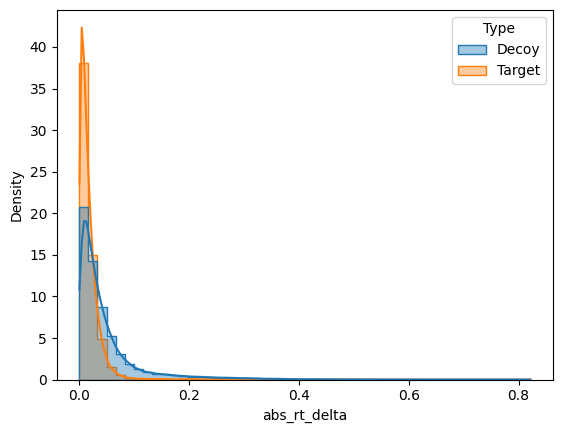

In [13]:
plot_target_decoy_dist(psm_df_all, metric='abs_rt_delta')


In [14]:
psm_df_all[rt_generator.feature_names].describe(percentiles=[.25, .5, .75, .9, .95, .99])


,rt_pred,delta_rt,abs_rt_delta,rt_ratio
count,338839.000000,338839.000000,3.388390e+05,338839.000000
mean,0.489519,-0.002833,3.195267e-02,0.930244
std,0.223160,0.059155,4.986366e-02,0.096226
min,0.042255,-0.759620,2.980232e-08,0.027711
25%,0.313210,-0.018798,7.351212e-03,0.918127
50%,0.478982,-0.001078,1.704502e-02,0.962152
75%,0.655532,0.015242,3.530604e-02,0.983892
90%,0.803624,0.039668,6.848822e-02,0.993854
95%,0.878822,0.064398,1.124214e-01,0.996974
99%,0.956671,0.180482,2.716389e-01,0.999403


In [15]:
# Evaluate each RT feature
for feature in rt_generator.feature_names:
    print(f"Evaluating {feature}...")
    
    # Check if feature has variation
    feature_values = psm_df_all[feature].dropna()
    if feature_values.std() < 1e-10:
        print(f"  Skipping {feature} - no variation in values")
        continue

    try:
        # For RT features, we need to consider that some are error metrics (lower is better)
        psm_df_eval = psm_df_all.copy()
        if feature in ['delta_rt', 'abs_rt_delta']:
            # For error metrics, invert so lower is better becomes higher is better
            psm_df_eval[f'{feature}_inverted'] = -psm_df_eval[feature]
            psm_df_eval = calc_fdr(psm_df_eval, score_column=f'{feature}_inverted', decoy_column='decoy')
        else:
            psm_df_eval = calc_fdr(psm_df_eval, score_column=feature, decoy_column='decoy')
    except Exception as e:
        print(f"  Error calculating FDR for {feature}: {e}")
        continue
    
    # Create 2-column figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Target-Decoy distribution
    try:
        # Disable KDE if data has low variation
        use_kde = feature_values.std() > 0.01
        plot_target_decoy_dist(psm_df_eval, feature, ax=axes[0], kde=use_kde)
        axes[0].set_title(f'{feature} - Target/Decoy Distribution')
    except Exception as e:
        print(f"  Error plotting distribution for {feature}: {e}")
        axes[0].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                     ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title(f'{feature} - Error in Distribution Plot')
    
    # Right: Q-value curve
    try:
        target_psms = psm_df_eval[psm_df_eval['decoy'] == 0]
        if len(target_psms) > 0:
            plot_qvalues(target_psms['fdr'].values, threshold=0.1, ax=axes[1])
            axes[1].set_title(f'{feature} - Discoveries at FDR')
        else:
            axes[1].text(0.5, 0.5, 'No target PSMs', 
                        ha='center', va='center', transform=axes[1].transAxes)
    except Exception as e:
        print(f"  Error plotting q-values for {feature}: {e}")
        axes[1].text(0.5, 0.5, f'Error: {str(e)[:50]}', 
                     ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title(f'{feature} - Error in Q-value Plot')
    
    plt.tight_layout()
    
    # Save to PDF
    pdf_path = output_dir / f'{feature}_evaluation.pdf'
    try:
        plt.savefig(pdf_path, bbox_inches='tight', dpi=300)
        print(f"  Saved to {pdf_path}")
    except Exception as e:
        print(f"  Error saving PDF for {feature}: {e}")
    finally:
        plt.close()

print(f"\nAll evaluations saved to {output_dir}")


Evaluating rt_pred...
  Saved to output/rt/rt_pred_evaluation.pdf
Evaluating delta_rt...
  Saved to output/rt/delta_rt_evaluation.pdf
Evaluating abs_rt_delta...
  Saved to output/rt/abs_rt_delta_evaluation.pdf
Evaluating rt_ratio...
  Saved to output/rt/rt_ratio_evaluation.pdf

All evaluations saved to output/rt


In [16]:
# Summary statistics
summary = []
for feature in rt_generator.feature_names:
    try:
        psm_df_eval = psm_df_all.copy()
        if feature in ['delta_rt', 'abs_rt_delta']:
            psm_df_eval[f'{feature}_inverted'] = -psm_df_eval[feature]
            psm_df_eval = calc_fdr(psm_df_eval, score_column=f'{feature}_inverted', decoy_column='decoy')
        else:
            psm_df_eval = calc_fdr(psm_df_eval, score_column=feature, decoy_column='decoy')
        
        targets_01fdr = ((psm_df_eval['fdr'] <= 0.01) & (psm_df_eval['decoy'] == 0)).sum()
        summary.append({
            'feature': feature,
            'targets_at_1pct_fdr': targets_01fdr
        })
    except Exception as e:
        print(f"Error processing {feature}: {e}")
        summary.append({
            'feature': feature,
            'targets_at_1pct_fdr': 0
        })

summary_df = pd.DataFrame(summary).sort_values('targets_at_1pct_fdr', ascending=False)
print("\nRT Feature Performance Summary (Targets at 1% FDR):")
print(summary_df)

# Save summary
summary_df.to_csv(output_dir / 'rt_feature_summary.csv', index=False)
summary_df



RT Feature Performance Summary (Targets at 1% FDR):
        feature  targets_at_1pct_fdr
1      delta_rt                    2
2  abs_rt_delta                    2
3      rt_ratio                    2
0       rt_pred                    0


,feature,targets_at_1pct_fdr
1,delta_rt,2
2,abs_rt_delta,2
3,rt_ratio,2
0,rt_pred,0
